<a href="https://colab.research.google.com/github/tucker-anderson/Facial-Keynotes/blob/master/Facial_Keypoints_Notebook_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Facial Keypoints Detection

Section 6; Summer 2019

**Team Members:**
- Tucker Anderson
- Bruno Todescan
- Madia Taher

In [3]:
# First setup environment
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import csv

from tensorflow import keras as keras
import tensorflow as tf


from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
# Colab setup:
# from google.colab import drive
# drive.mount('/content/drive')

# Define constants:
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

# Exploratory Data Analysis
Let's take a quick look at the data to understand a little about formatting, ranges, relationships, etc. 

In [5]:
lookid_data = pd.read_csv("IdLookupTable.csv")
lookid_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [6]:
# Take a quick look at the submission data
samplesubmission = pd.read_csv("SampleSubmission.csv")
samplesubmission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
test_data_df = pd.read_csv("test.csv")
test_data_df.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [8]:
# Take a quick look at the training data:
train_data = pd.read_csv("training.csv")
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [9]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

Let's try codifying the null values to -1 to see how the model handles fitting these.

In [39]:
train2 = train_data.copy()

In [40]:
train2.fillna(value=-1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
5,69.680748,39.968748,29.183551,37.563364,62.864299,40.169271,76.898243,41.171888,36.401047,39.367626,...,58.800000,64.869084,82.471178,31.990430,81.669084,49.308112,78.487626,49.432374,93.898766,167 169 170 167 156 145 106 68 52 24 20 15 21 ...
6,64.131866,34.290040,29.578953,33.138040,57.797154,35.154040,69.026577,34.290040,34.761664,33.714040,...,53.006174,55.781799,70.570953,33.898309,70.282953,45.127732,65.099597,45.415732,78.057020,109 109 125 141 145 139 120 81 45 34 31 35 36 ...
7,67.468893,39.413452,29.355961,39.621717,59.554951,40.454773,75.591612,40.038245,37.478214,40.454773,...,56.907961,66.843961,80.025786,30.189204,81.275184,48.100194,71.278602,48.516816,91.063922,178 177 178 179 179 179 181 185 188 184 192 20...
8,65.802880,34.755200,27.475840,36.185600,58.652160,37.329280,72.952960,35.899520,36.342400,37.043200,...,55.348480,65.516800,73.368320,31.194240,74.798080,49.213440,67.648000,49.499520,83.093120,164 158 118 76 66 69 59 53 43 31 35 41 45 55 6...
9,64.121231,36.740308,29.468923,38.390154,58.620923,37.840615,71.272000,37.290338,36.344615,39.490462,...,54.341538,65.771692,69.192615,32.769231,72.217846,49.270154,67.542769,49.545231,76.893538,226 227 225 224 221 220 215 210 210 208 206 18...


In [10]:
len(train_data)

7049

In [11]:
print(train_data.count())# prints the number of values for each column
print(len(train_data))
df = train_data.dropna()  # drop all rows that have missing values in them
len(df)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

2140

There are clearly lots of missing values in the example data set. This is ok though, since we don't need (or even want) a "perfect" data set for our model, since this can cause over fitting. Additionally, if we would to restrict our training data set to only the images with all valid number results, we would end up reducing our training set by almost 2/3, which could also lead to poor generalization.

## Training Data

Let's take a deeper look at our training data, since this is what we will be mostly focused on.

In [12]:
# Check for duplicates
# Remove Image column
td_remove_image=train_data.drop(['Image'], axis=1)
td_remove_image.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [13]:
duplicate_imgs = td_remove_image[td_remove_image.duplicated()]
len(duplicate_imgs)

0

So we don't have any *exact* duplicates in the data set, which although good to know, would not have affected our results tremendously.

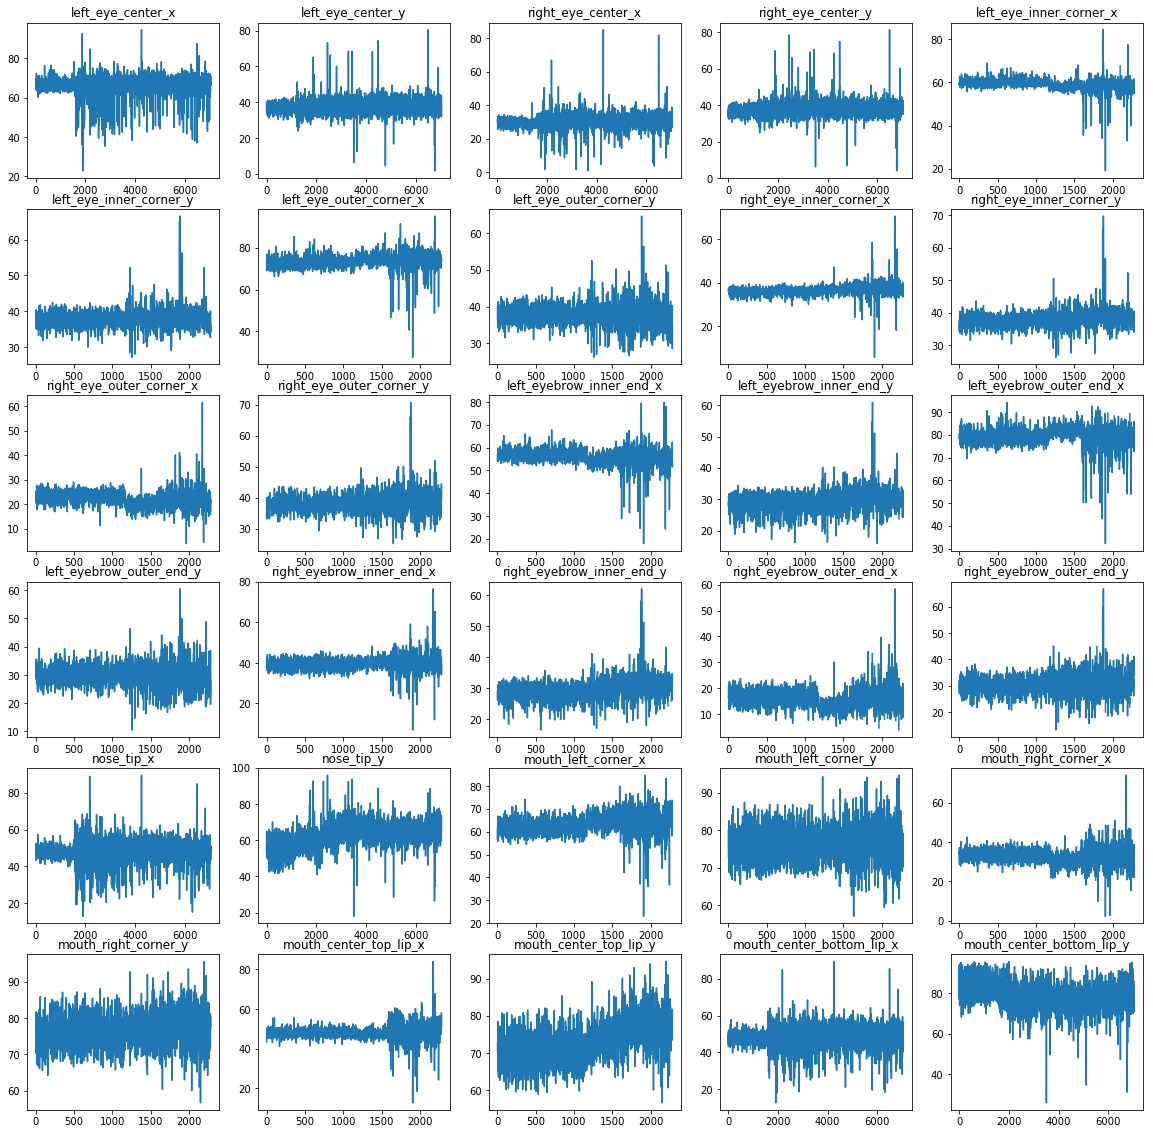

In [14]:
# Let's take a look at what the values look like. We use a line plot here and use histograms to below.
column_list=list(train_data.columns.values)
fig, ax = plt.subplots(figsize=(20,20),nrows=6, ncols=5)

i=0
for row in ax:
    for col in row:
        col.plot(train_data[column_list[i]])
        col.set_title(column_list[i])
        i=i+1

plt.show()

a = train_data.iloc[:,0].copy()

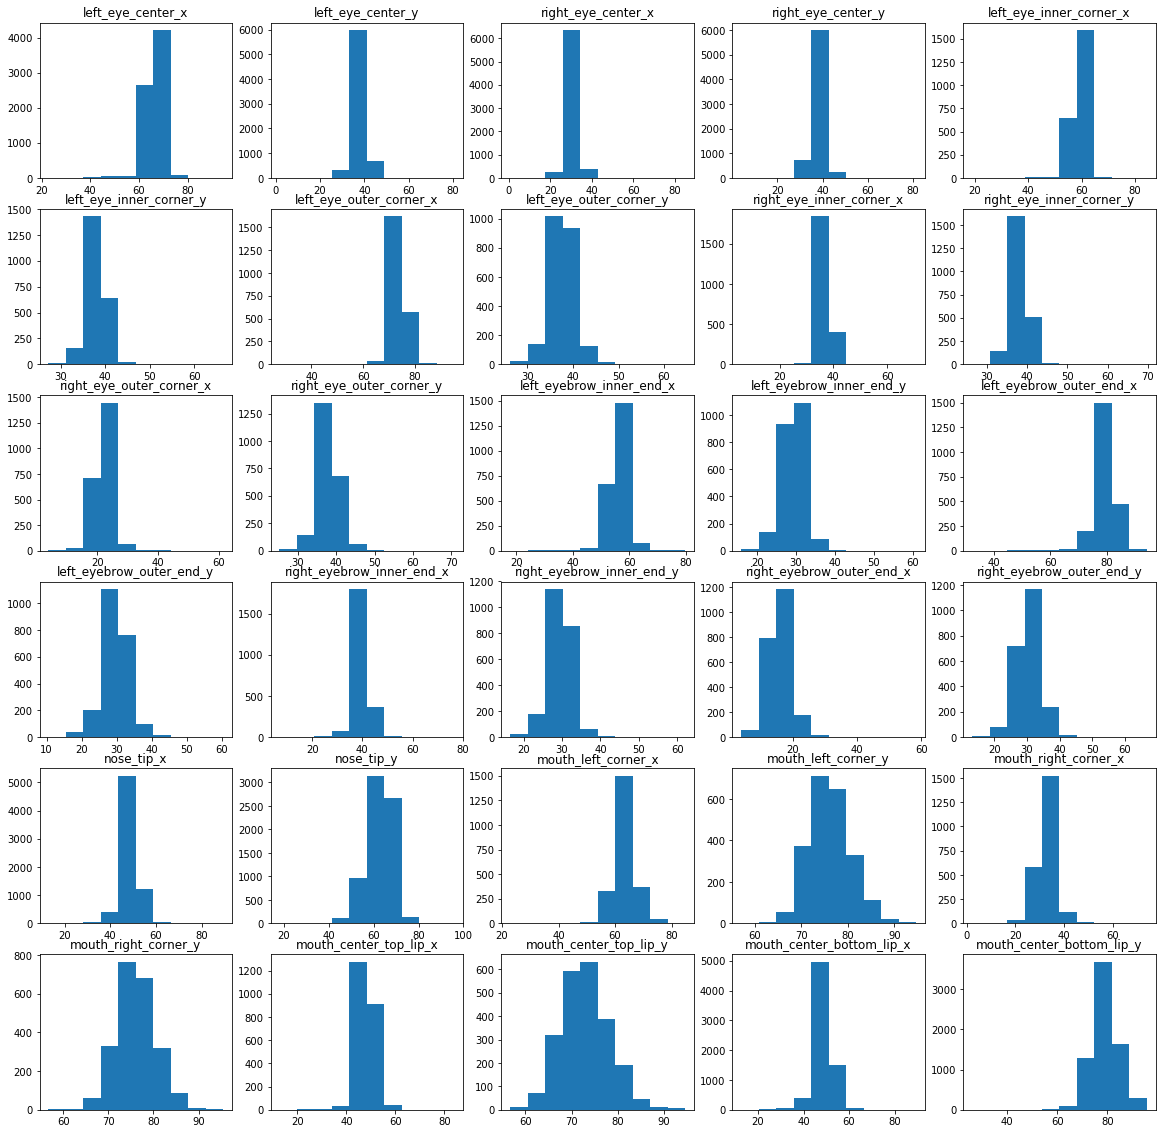

In [15]:
# What do the distributions look like (in 1-D)?
column_list=list(train_data.columns.values)
fig, ax = plt.subplots(figsize=(20,20),nrows=6, ncols=5)

i=0
for row in ax:
    for col in row:
        col.hist(train_data[column_list[i]].dropna())
        col.set_title(column_list[i])
        i=i+1

plt.show()

So from the above two cell results (line plots and histograms) we can see that the values are generally pretty tightly grouped around the same values.

## 2-D EDA

This only tells us half the story - since we are looking at coordinates in two dimensions, we take a look at what the feature vlaue ranges look like together, as X and Y pairs.

Before we can do this, we create some helper funcitons to split our trianing data set into the 'train' and 'test' components (image data and results data) and show the images when passed image data.

### Helper Functions

In [16]:
# this function will take a data frame as an input and spit out two numpy arrays as a result:
# one ('labels') for the labels only (columns 0 to 29) for each of the features we are predicting, and
# another ('data') for the image pixel data corresponding to a 9216-long array of integer values between 0 and 255.
def trainDataLabelSplit(df):
    # assuming a dataframe input
    
    # create a DF of just the labels
    labels = np.array(df.iloc[:,:30])
    length = len(df)
#     length = 2

    data = np.empty(shape=(length,96,96,1))
    
    start = time.time()
    for i in range(length):
        data[i] = np.array(df.iloc[i,30].split()).reshape(96,96,1)
        if i % 500 == 0:
            print('%d: %.5f seconds elapsed.'%(i,time.time()-start))
    
    return labels, data.astype('int16')

In [17]:
start = time.time()
Ytrain, Xtrain = trainDataLabelSplit(train_data)
end = time.time()
print('Total %9.5f seconds.' %(end-start))

0: 0.00751 seconds elapsed.
500: 2.12480 seconds elapsed.
1000: 4.22849 seconds elapsed.
1500: 6.31317 seconds elapsed.
2000: 8.41047 seconds elapsed.
2500: 10.57908 seconds elapsed.
3000: 12.88762 seconds elapsed.
3500: 15.41486 seconds elapsed.
4000: 18.25086 seconds elapsed.
4500: 20.67604 seconds elapsed.
5000: 22.97584 seconds elapsed.
5500: 25.95206 seconds elapsed.
6000: 28.54856 seconds elapsed.
6500: 31.22803 seconds elapsed.
7000: 33.54352 seconds elapsed.
Total  33.93869 seconds.


In [18]:
# Take a dataframe as input expecting it to have been read from the test.csv input file.
# Reshape this data and return it as an numpy array.
def load_test_set(df):
    length = len(df)

    data = np.empty(shape=(length,96,96,1))
    
    start = time.time()
    for i in range(length):
        data[i] = np.array(df.iloc[i,1].split()).reshape(96,96,1)
        if i % 500 == 0:
            print('%d: %.5f seconds elapsed.'%(i,time.time()-start))
    
    return data.astype('int16')

In [19]:
start = time.time()
test_data = load_test_set(test_data_df)
end = time.time()
print('Total %9.5f seconds.' %(end-start))

0: 0.00613 seconds elapsed.
500: 2.30517 seconds elapsed.
1000: 4.50994 seconds elapsed.
1500: 6.66367 seconds elapsed.
Total   7.86997 seconds.


In [30]:
# This function takes as an input the image data and an array of labels in the 
# form of [x0, y0, x1, y1, ...] coordinates and overlays the label points on the image.
def show_image_labels(img, labels):
    for i in range(0, len(labels), 2):
        if labels[i+1] >= 0 and labels[i+1] <=255 and labels[i] >= 0 and labels[i] <= 255:
            img[int(labels[i+1]),int(labels[i]),:] = 255
    plt.imshow(img[:,:,0], cmap='viridis')

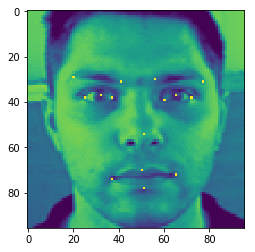

In [31]:
n = 3
show_image_labels(Xtrain[n], Ytrain[n])

Now we're ready to take a closer look at some of the data.

**Potentially interesting to look at:**
* distribution of the pixel values in 2D (where do we see concentrations?)
* distribution of the feature values in 2D

### Pixel Value Distributions
To get an idea about our data set, we can see what the densities are like for the image set. This can be accomplished by summing all the pixel values and plotting these. The imshow() command will automatically scale these representing a density plot.

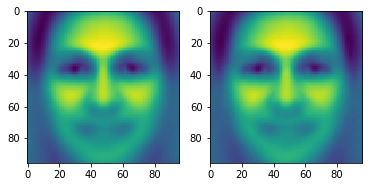

In [22]:
# To look at image densities, we "overlay" them by summing all the values at each pixel. 
# Higher values will show higher densities overall.

pixel_sums_train = np.zeros((96,96))
pixel_sums_test = np.zeros((96,96))

for r in range(96):
    for c in range(96):
        pixel_sums_train[r,c] = np.sum(Xtrain[:,r,c,0]/255)
        pixel_sums_test[r,c] = np.sum(test_data[:,r,c,0]/255)

plt.subplot(1,2,1)
plt.imshow(pixel_sums_train, cmap='viridis')
plt.subplot(1,2,2)
plt.imshow(pixel_sums_test, cmap='viridis')

This plot shows a few interesting points. The forehead, eyes, nose and cheeks are quite distinct, meaning that the majority of our images are centered in approximately the same location. The blurring above the lips and around the mouth area is likely due to mustaches, smiles vs frowns, etc. We can also see that our training and test sets generated similar images, so we should expect our model to perform relatively well to the test data set, though generalizability is something we'll need to look out for.

Based on this, one could assume that the a model may be more accurate with predictions of where the eyes and nose are, while having poorer accuracy with the mouth and potentially the ends of the eyebrows.

### Facial Keypoints Distributions

To take a deeper look at our dataset, we investigate where we our keypoints generally lie. This will help to identify any outlier images, and reinfornce the observations made in the previous step with the heatmaps.

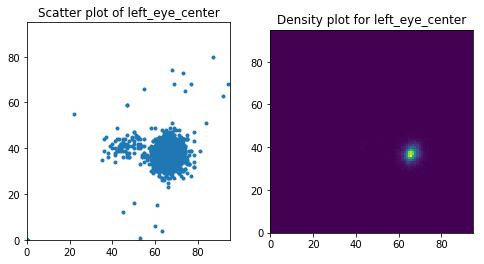

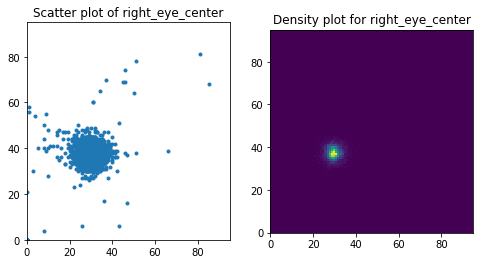

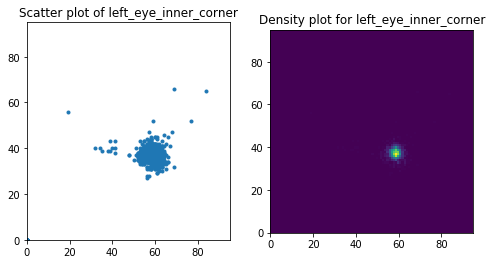

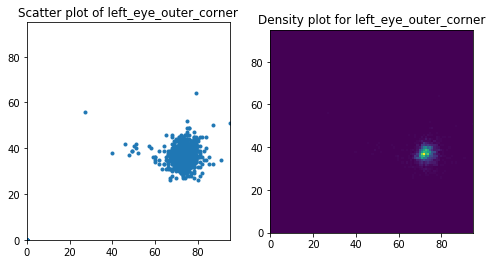

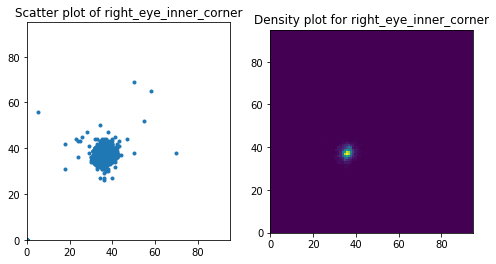

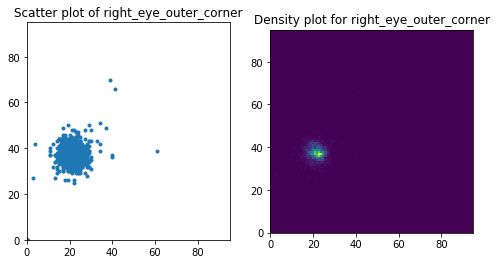

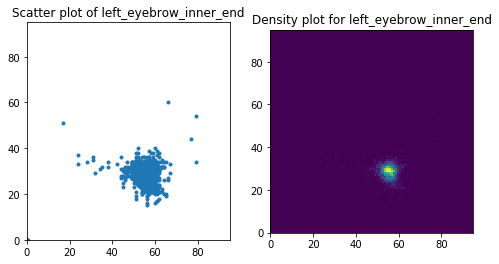

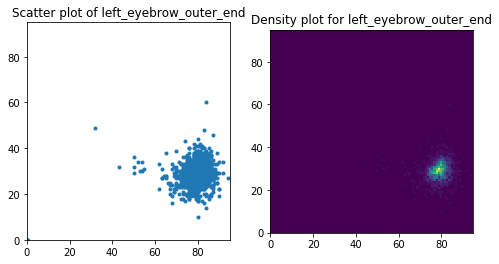

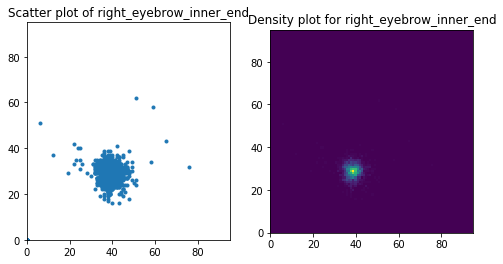

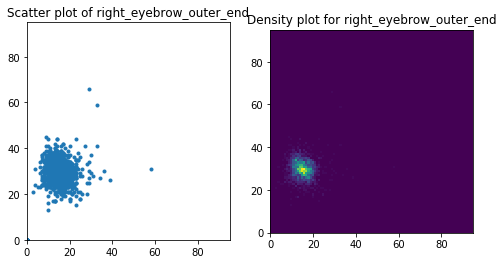

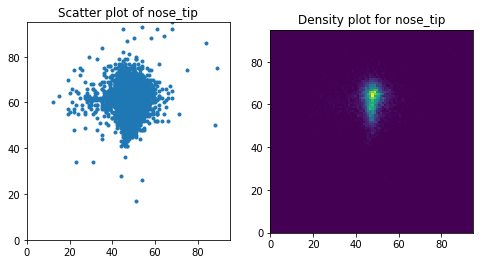

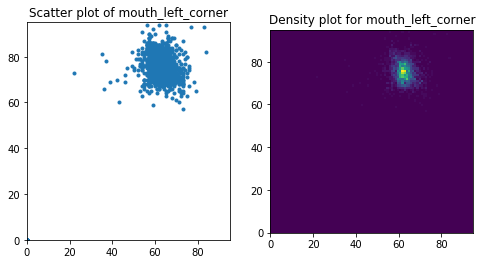

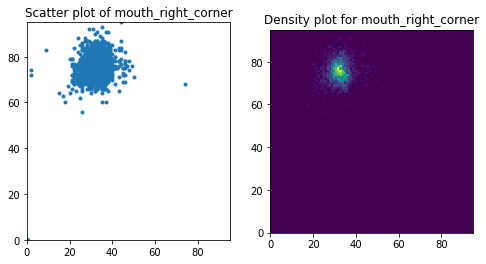

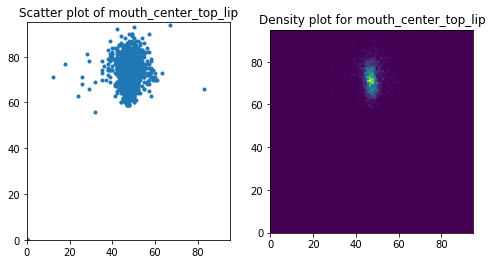

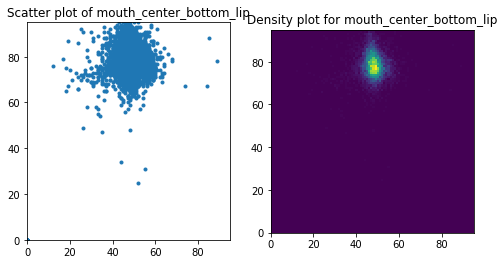

In [28]:
IMG_H = IMG_W = 96

def get_feature_density(feature_ind, label_array):
    feature_density = np.zeros((IMG_H, IMG_W))
    for i in range(len(label_array)):
        c = Ytrain[i,feature_ind]
        r = Ytrain[i,feature_ind+1]
        if ~np.isnan(r) and ~np.isnan(c):
            feature_density[int(r),int(c)] += 1
    return feature_density


column_list=list(train_data.columns.values)
for i in range(0,30,2):
    # Scatter plot of ALL values for each feature (in X and Y)
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    ax1.scatter(x=Ytrain[:,i].astype('int8'), y=Ytrain[:,i+1].astype('int8'), marker='.')
    ax1.set_xlim(0,IMG_W-1)
    ax1.set_ylim(0,IMG_H-1)
    ax1.set_title(('Scatter plot of '+column_list[i][:-2]))

    # View the same data as a density plot:
    ax2 = plt.subplot(1,2,2)
    ax2.imshow(get_feature_density(i,Ytrain), cmap='viridis')
    ax2.set_xlim(0,IMG_W-1)
    ax2.set_ylim(0,IMG_H-1)
    ax2.set_title(('Density plot for '+column_list[i][:-2]))

    plt.show()

We can see that although the features take on a variety of values, they are mostly clustered around a smaller set of points (with few outliers). This aligns with the findings above where we saw the "average" image for our data set.

# Training a Baseline Neural Net Model

Although we have been looking at the complete data set (including training exmaples where some features do not exist), for the purposes of training a model we need to clean out the NaNs and null values.

In [48]:
Ytrain_clean, Xtrain_clean = trainDataLabelSplit(train_data.dropna())

0: 0.01750 seconds elapsed.
500: 2.14942 seconds elapsed.
1000: 4.27393 seconds elapsed.
1500: 6.32238 seconds elapsed.
2000: 8.34242 seconds elapsed.


In [49]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten

m = Sequential()
m.add(Flatten(input_shape = Xtrain_clean[1].shape))

m.add(Dense(128, activation = 'relu'))
m.add(Dense(64, activation = 'relu'))
m.add(Dense(30))

m.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'acc'])

In [51]:
m.fit(Xtrain_clean, Ytrain_clean, epochs = 10, batch_size=50)

Epoch 1/10
2140/2140 [==============================] - 6s 3ms/step - loss: 362.0403 - mean_squared_error: 362.0403 - acc: 0.1168
Epoch 2/10
2140/2140 [==============================] - 5s 3ms/step - loss: 236.3416 - mean_squared_error: 236.3416 - acc: 0.2864
Epoch 3/10
2140/2140 [==============================] - 5s 3ms/step - loss: 197.9962 - mean_squared_error: 197.9962 - acc: 0.3201
Epoch 4/10
2140/2140 [==============================] - 5s 3ms/step - loss: 188.7196 - mean_squared_error: 188.7196 - acc: 0.3117
Epoch 5/10
2140/2140 [==============================] - 5s 2ms/step - loss: 178.2271 - mean_squared_error: 178.2271 - acc: 0.3182
Epoch 6/10
2140/2140 [==============================] - 5s 3ms/step - loss: 171.4635 - mean_squared_error: 171.4635 - acc: 0.3210
Epoch 7/10
2140/2140 [==============================] - 6s 3ms/step - loss: 166.4500 - mean_squared_error: 166.4500 - acc: 0.3154
Epoch 8/10
2140/2140 [==============================] - 9s 4ms/step - loss: 159.6684 - mea